--- 
description: The shift optimization problem is the problem of finding the optimal cost under several constraints.
---

# Shift Optimization Problem

The shift optimization problem is the problem of finding the optimal cost under several constraints.
Here we show an example of shift optimization based on [This formulation](https://scmopt.github.io/opt100/81shift-minimization.html).

## Problem Description

### Overview

Suppose that we want to allocate multiple jobs to multiple workers.
You have to pay a cost per worker.
Given the start time and end time of each job and the costs of each worker, minimize the workers' cost under the constraints;

* Each job needs one worker
* A worker cannot do multiple jobs at the same time

The figure below is a picture of the shift optimization problem.

![](./assets/shift_opt01.png)

There are three jobs and three workers in this situation.
Since job A and B have no overlap. One worker can do these jobs, costing a total $300.

## Pre-process

Before constructing a mathematical model, we list overlapping jobs from the given job schedule.
First, we prepare the job scheduling data (list of (start_time, end_time)):

In [1]:
from datetime import time
job_list = [
        (time(17, 0), time(18, 0)), # job 0
        (time(13, 0), time(14, 0)), # job 1
        (time(13, 30), time(14, 30)), # job 2
        (time(13, 40), time(14, 40)), # job 3
        (time(16, 40), time(17, 40)), # job 4
        (time(11, 40), time(13, 40)), # job 5
        (time(18, 40), time(19, 40)), # job 6
        (time(18, 40), time(19, 40)), # job 7
        (time(18, 00), time(19, 00)), # job 8
    ]

To find overlapping jobs, we first create a graph whose node `i` corresponds to each job `job_list[i],` and the edge connects overlapping jobs.

We need the networkx library to run the below code.

In [2]:
import networkx as nx

def has_overlap(t1start: time, t1end: time, t2start: time, t2end: time):
    return (t1start <= t2start <= t1end) or (t2start <= t1start <= t2end)

def gen_index_graph(time_list: list[tuple[time, time]]) -> nx.Graph:
    G = nx.Graph()
    for j in range(len(time_list)):
        for k in range(j + 1, len(time_list)):
            if has_overlap(
                time_list[j][0], time_list[j][1], time_list[k][0], time_list[k][1]
            ):
                G.add_edge(j, k)

    return G

We can get the list of overlapping jobs by finding cliques from the graph. The function `nx.find_cliques` can be used for extracting cliques.

In [3]:
g = gen_index_graph(job_list)
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

print(job_cliques)

[[0, 8], [0, 4], [1, 2, 3, 5], [8, 6, 7]]


For example, job 0 (from 17:00 to 18:00) and job 8 (from 18:00 to 19:00) has overlap at 18:00 hence it listed as `[0, 8]`.
Job 1, 2, 3, 5 are overlapped each other hence it is also listed.

## Mathematical Model

### Constants

We use the following constants:

* $W$: The number of workers (e.g. `5`)
* $J$: The number of jobs (e.g. `5`)
* $b_w$: Costs of the worker w. (e.g. `[1,2,3,2,1]`)
* $C$: List of overlapped jobs (e.g. `[[1,4], [4,2,3,5], [2,3]]`. Note that $C_0$ = `[1,4]`, $C_1$ = `[4,2,3,5]`, $C_2$ = `[2,3]`)
* $Nc$: The number of overlapped jobs (=`len(C)`)

### Decision Variables

A binary variables $x_{j,w}$ and $y_{w}$ are defined as:
$$
x_{j,w} = \begin{cases}
1~\text{the worker {\it w} is assigned to the job {\it j}}\\
0~\text{otherwise}\\
\end{cases}
$$

$$
y_{w} = \begin{cases}
1~\text{the worker {\it w} is assigned}\\
0~\text{the worker {\it w} is not assigned}\\
\end{cases}
$$

for all $j \in \{0, ..., J-1\}$ and $w \in \{0, ..., W-1\}$.

### Objective Functions

The cost function to be minimized is the total cost of workers:

$$
\min \sum_w b_{w} y_{w}
$$

### Constraints

We first consider two constraints;

* Each job needs one worker
$$
\sum_w x_{j, w} = 1, ~\forall j \in \{0, ..., J-1\}
$$

* A worker cannot do multiple jobs at the same time. In other words, the number of jobs in $C_c$ that the worker $w$ is assigned is 0 (if $y_{w}$ is 0) or 1 (if $y_{w}$ is 1).

$$
\sum_{l \in C_{c}} x_{l, w} \leq y_{w}, ~\forall w \in \{0, ..., W-1\}, c \in \{0, ..., Nc-1\}
$$

## Modeling by JijModeling

In [4]:
import jijmodeling as jm

W = jm.Placeholder("W")
w = jm.Element("w", belong_to=W)
# jobs
J = jm.Placeholder("J")
j = jm.Element("j", belong_to=J)

# workers cost
b = jm.Placeholder("b", ndim=1)

# list of overlapped jobs
C = jm.Placeholder("C", ndim=2)
# number of cliques
Nc = jm.Placeholder("Nc")
# index for clique
c = jm.Element("c", belong_to=Nc)
l = jm.Element("l", belong_to=C[c])

# decision variables
# 1 if the worker w is assigned, otherwise 0.
y = jm.BinaryVar("y", shape=(W,))
# 1 if the worker w is assigned to job j.
x = jm.BinaryVar("x", shape=(J, W))

problem = jm.Problem("shift schedule")

problem += jm.sum(w, b[w] * y[w])

problem += jm.Constraint("const_do_all_jobs", jm.sum(w, x[j, w]) == 1, forall=[j])

problem += jm.Constraint(
    "const_worker_limit", jm.sum(l, x[l, w]) <= y[w], forall=[w, c]
)

problem

## Solve by JijZept

Let us calculate with five workers and five jobs.
We can use [parameter search algorithm](https://www.documentation.jijzept.com/docs/jijzept_docs/parameter_search) to solve the problem.

In [5]:
import jijzept as jz

workers_costs = [1, 4, 3, 2, 5]
job_list = [
        (time(17, 0), time(18, 0)),
        (time(13, 0), time(14, 0)),
        (time(13, 30), time(14, 30)),
        (time(13, 40), time(14, 40)),
        (time(16, 40), time(16, 50)),
    ]

# Pre-process to job_list
g = gen_index_graph(job_list)
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

instance_data = {
            "W": len(workers_costs),
            "J": len(job_list),
            "b": workers_costs,
            "C": job_cliques,
            "Nc": len(job_cliques),
        }

config_path = "config.toml"
sampler = jz.JijSASampler(config=config_path)
response = sampler.sample_model(
    problem, instance_data, search=True, num_search=15
    )

print(response.status)

APIStatus.SUCCESS


## Visualization

First, let us check the objective (the cost function) from feasible solutions.

In [6]:
# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
# get the values of feasible objectives
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
feasible_objectives

[6.0, 6.0, 6.0, 6.0, 6.0, 6.0]

The lowest solution is 6.

Next, we will plot the generated job schedule from the feasible lowest solution.

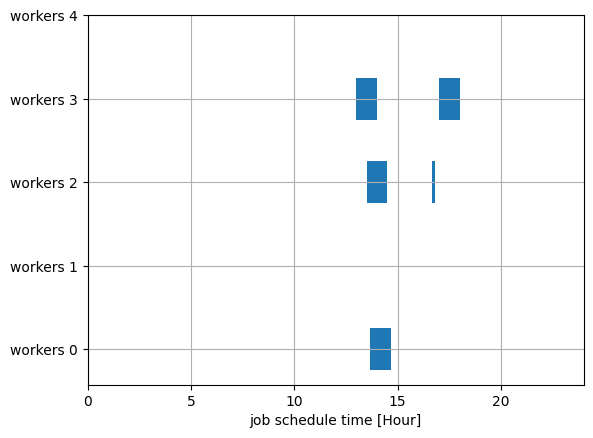

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sol(job_list: list[tuple[time, time]], y: list[int], x: list[list[int]]):

    # convert time to sec

    factor = 24 / 86400

    bar_job_list = [((e1.hour*3600 + e1.minute*60 + e1.second) * factor, ((e2.hour*3600 + e2.minute*60 + e2.second) - (e1.hour*3600 + e1.minute*60 + e1.second)) * factor) for e1, e2 in job_list]

    # Horizontal bar plot with gaps
    fig, ax = plt.subplots()
    for i,val in enumerate(y):
        if val == 1:
            bar = []
            for j in range(len(bar_job_list)):
                if x[j, i] == 1:
                    bar.append(bar_job_list[j])

            ax.broken_barh(bar, (10*(i+1)-2.5, 5))

    ax.set_xlim(0, 24)
    ax.set_xlabel("job schedule time [Hour]")
    ax.set_yticks([10*(i+1) for i,_ in enumerate(y)], labels=[f"workers {i}" for i,_ in enumerate(y)])  # Modify y-axis tick labels
    ax.grid(True)  # Make grid lines visible

    plt.show()

# get the index of lowest feasible objective
lowest_index = np.argmin(feasible_objectives)
# get the indices of y == 1
solution_y = feasible_samples[lowest_index].var_values["y"].to_dense()
# get the indices of x == 1
solution_x = feasible_samples[lowest_index].var_values["x"].to_dense()
plot_sol(job_list, solution_y, solution_x)

The blue area shows each job. You can see that only three workers can do the jobs, and the total cost is 1+2+3=6.

## Other Cases

Let us consider if all jobs are overlapped.

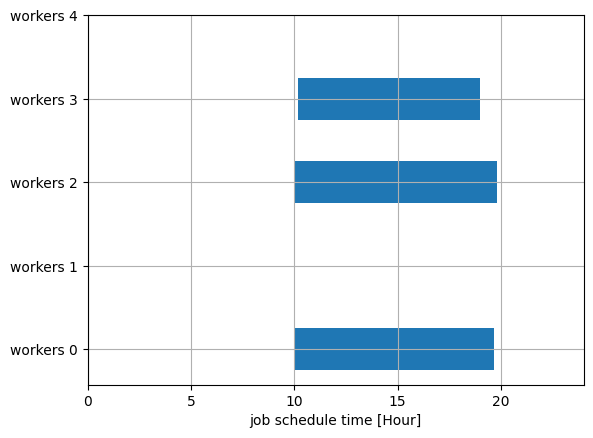

In [8]:
import jijzept as jz

workers_costs = [1, 4, 3, 2, 5]
job_list = [
        (time(10, 10), time(19, 0)),
        (time(10, 20), time(19, 0)),
        (time(10, 30), time(19, 30)),
        (time(10, 0), time(19, 40)),
        (time(10, 0), time(19, 50)),
    ]

# Pre-process to job_list
g = gen_index_graph(job_list)
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

instance_data = {
            "W": len(workers_costs),
            "J": len(job_list),
            "b": workers_costs,
            "C": job_cliques,
            "Nc": len(job_cliques),
        }

sampler = jz.JijSASampler(config=config_path)
res = sampler.sample_model(
    problem, instance_data, search=True, num_search=15
    )

# get the index of lowest feasible objective
lowest_index = np.argmin(feasible_objectives)
# get the indices of y == 1
solution_y = feasible_samples[lowest_index].var_values["y"].to_dense()
# get the indices of x == 1
solution_x = feasible_samples[lowest_index].var_values["x"].to_dense()
plot_sol(job_list, solution_y, solution_x)

In this case, we need all workers to finish jobs.